In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [15]:
# upload kaggle api creds to this week's directory, then do this!
!mkdir /.kaggle
!mv /floyd/home/week-2/kaggle.json /.kaggle/kaggle.json

mkdir: cannot create directory ‘/.kaggle’: File exists
mv: cannot stat '/floyd/home/week-2/kaggle.json': No such file or directory


In [3]:
path = Path(Config.get_key('data_path')).expanduser()/'planet'
os.makedirs(path, exist_ok=True)
path

PosixPath('/floyd/home/fastai/data/planet')

In [19]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path} 

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 11, in <module>
    load_entry_point('kaggle==1.4.6', 'console_scripts', 'kaggle')()
  File "/usr/local/lib/python3.6/site-packages/pkg_resources/__init__.py", line 480, in load_entry_point
    return get_distribution(dist).load_entry_point(group, name)
  File "/usr/local/lib/python3.6/site-packages/pkg_resources/__init__.py", line 2691, in load_entry_point
    return ep.load()
  File "/usr/local/lib/python3.6/site-packages/pkg_resources/__init__.py", line 2322, in load
    return self.resolve()
  File "/usr/local/lib/python3.6/site-packages/pkg_resources/__init__.py", line 2328, in resolve
    module = __import__(self.module_name, fromlist=['__name__'], level=0)
  File "/usr/local/lib/python3.6/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.6/site-packages/kaggle/api/kaggle_api_extended.py", line 109, in authenticate
    self._load_config(config_data)


In [22]:
! sudo apt-get update
! sudo apt-get install p7zip-full

Get:1 http://storage.googleapis.com/bazel-apt stable InRelease [2464 B]
Get:2 http://ppa.launchpad.net/git-core/ppa/ubuntu xenial InRelease [17.5 kB]
Get:3 http://storage.googleapis.com/bazel-apt stable/jdk1.8 amd64 Packages [621 B]
Get:4 http://security.ubuntu.com/ubuntu xenial-security InRelease [107 kB]
Get:5 https://deb.nodesource.com/node_8.x xenial InRelease [4646 B]
Get:6 https://deb.nodesource.com/node_8.x xenial/main Sources [761 B]
Get:7 http://ppa.launchpad.net/git-core/ppa/ubuntu xenial/main amd64 Packages [3514 B]
Get:8 https://deb.nodesource.com/node_8.x xenial/main amd64 Packages [1006 B]
Get:9 https://packagecloud.io/github/git-lfs/ubuntu xenial InRelease [23.2 kB]
Get:10 https://packagecloud.io/github/git-lfs/ubuntu xenial/main amd64 Packages [6850 B]
Get:11 http://security.ubuntu.com/ubuntu xenial-security/universe Sources [102 kB]
Get:12 http://security.ubuntu.com/ubuntu xenial-security/main amd64 Packages [733 kB]
Get:13 http://security.ubuntu.com/ubuntu xenial-secu

In [23]:
!7za -bd -y x {path}/train-jpg.tar.7z -o{path}
!tar -xf {path}/train-jpg.tar -C {path}


7-Zip (A) [64] 9.20  Copyright (c) 1999-2010 Igor Pavlov  2010-11-18
p7zip Version 9.20 (locale=C.UTF-8,Utf16=on,HugeFiles=on,2 CPUs)

Processing archive: /floyd/home/fastai/data/planet/train-jpg.tar.7z

Extracting  train-jpg.tar

Everything is Ok

Size:       665753600
Compressed: 629296207


In [24]:
path.ls()

[PosixPath('/floyd/home/fastai/data/planet/train-jpg.tar'),
 PosixPath('/floyd/home/fastai/data/planet/train_v2.csv.zip'),
 PosixPath('/floyd/home/fastai/data/planet/train-jpg'),
 PosixPath('/floyd/home/fastai/data/planet/__MACOSX'),
 PosixPath('/floyd/home/fastai/data/planet/train-jpg.tar.7z'),
 PosixPath('/floyd/home/fastai/data/planet/train_v2.csv')]

## Finally, time for Multiclassification

Here, each picture can have multiple labels. Each image name is associated with several tags separated by spaces.

In [4]:
df = pd.read_csv(path/'train_v2.csv')

In [5]:
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [6]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [7]:
np.random.seed(42)

In [8]:
data = (ImageFileList.from_folder(path)
       .label_from_csv('train_v2.csv', sep=' ', folder='train-jpg', suffix='.jpg')
       .random_split_by_pct(0.2)
       .datasets(ImageMultiDataset)
       .transform(tfms, size=128)
       .databunch()
       .normalize(imagenet_stats))

/usr/local/lib/python3.6/site-packages/fastai/vision/data.py:122: UserWarning: `ImageMultiDataset` is deprecated and will soon be removed. Use the data block API.
  warnings.warn("`ImageMultiDataset` is deprecated and will soon be removed. Use the data block API.")


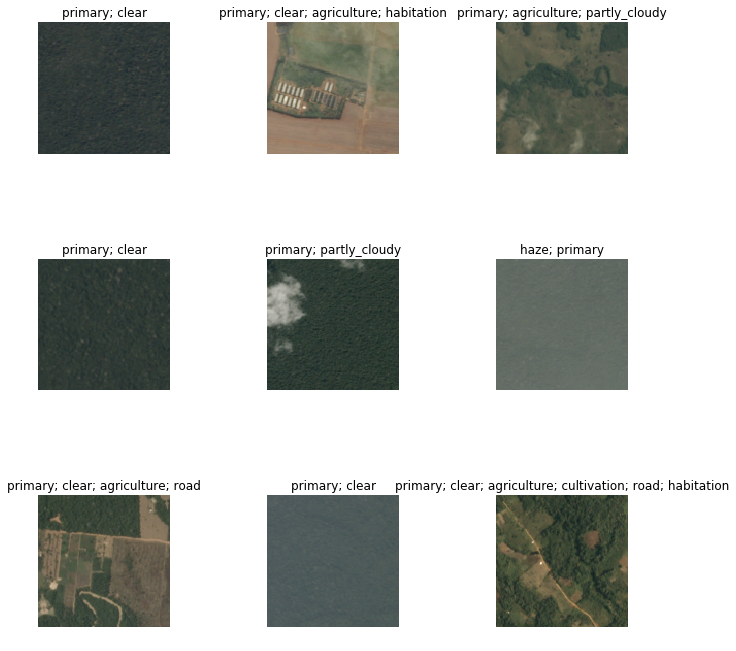

In [7]:
data.show_batch(rows=3, figsize=(10, 10))

Base architecture is resnet34 again, but we are using accuracy_thresh instead of accuracy. In this case, an activation can be 0 or 1. Accuracy_thread selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth

In [8]:
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, models.resnet34, metrics=[accuracy_thresh, f_score])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:02<00:00, 37109076.08it/s]


In [9]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


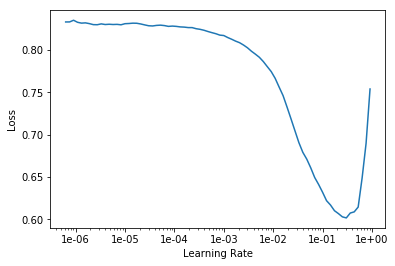

In [10]:
learn.recorder.plot()

In [11]:
lr = 0.02

In [12]:
learn.fit_one_cycle(5, lr)

Total time: 10:42
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.120614    0.124041    0.953377         0.889159  (02:17)
2      0.122669    0.120155    0.953741         0.892836  (02:06)
3      0.115843    0.103307    0.959605         0.907510  (02:06)
4      0.101299    0.091581    0.964720         0.921300  (02:07)
5      0.096088    0.088132    0.965476         0.922656  (02:04)

